In [10]:
# 📘 1. Filtro RC pasa bajos (Low-Pass)

### Topología:
# Vin — R —+—— Vout
#             |
#             C
#           GND

# Este es un filtro clásico de primer orden con función de transferencia:
# H(s) = 1 / (1 + sRC)
#
# Su versión en WDF:
# - Resistor seguido de Capacitor, conectados con SeriesAdaptor.
# - Salida tomada en el capacitor.

from pywdf.core.wdf import Resistor, Capacitor, SeriesAdaptor, IdealVoltageSource, Inductor
from pywdf.core.circuit import Circuit
import numpy as np
from scipy.io.wavfile import write

class RCLowPass(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff

        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        self.R1 = Resistor(self.R)
        self.C1 = Capacitor(self.C, self.fs)

        self.S1 = SeriesAdaptor(self.R1, self.C1)
        self.Vs = IdealVoltageSource(self.S1)

        super().__init__(source=self.Vs, root=self.Vs, output=self.C1)


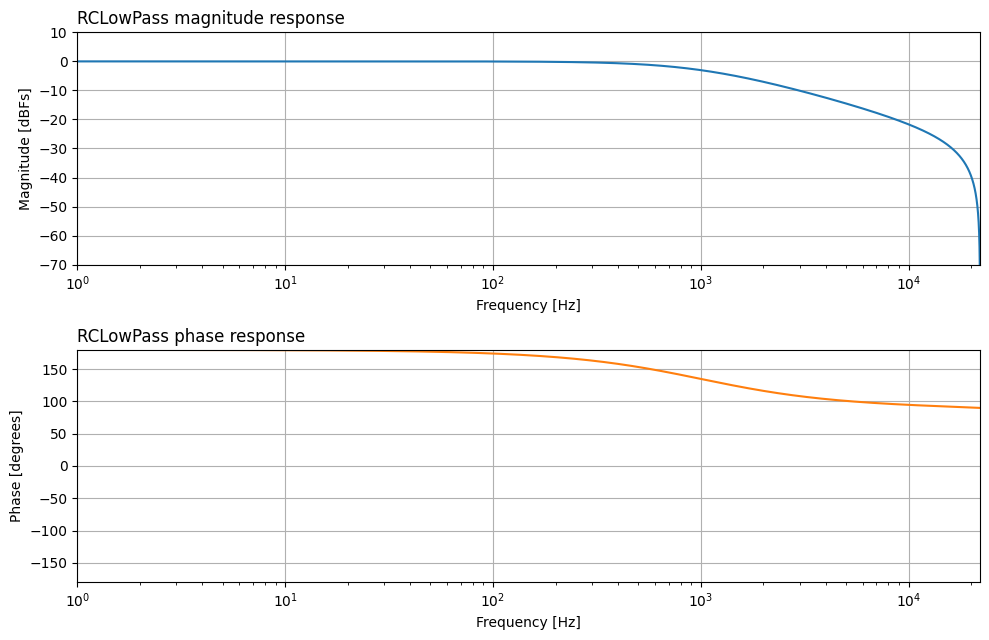

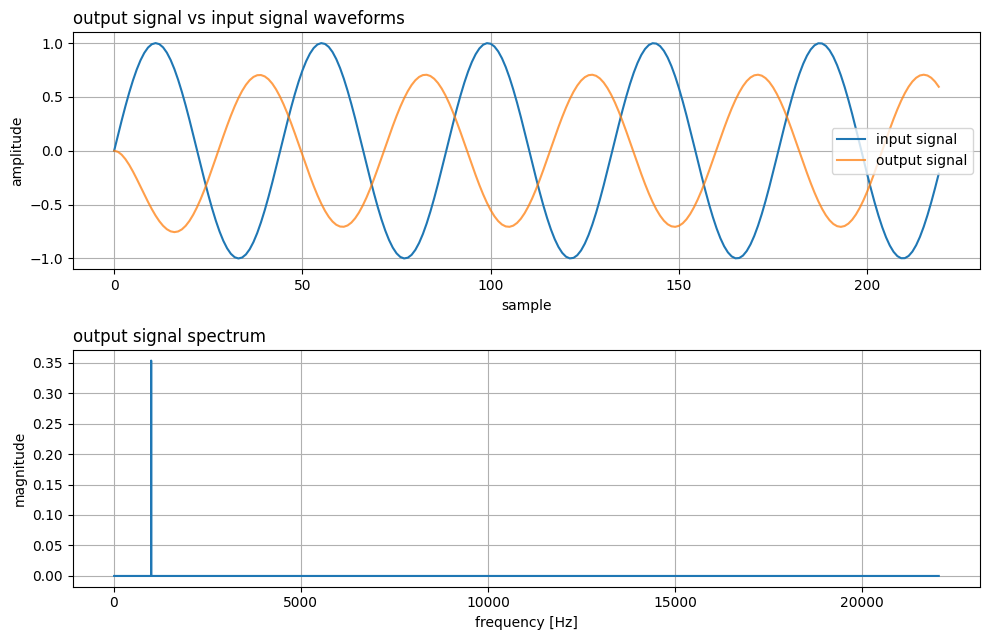

In [11]:
# 📊 Análisis del LowPass
lpf = RCLowPass(fs=44100, cutoff=1000)
lpf.plot_freqz()
lpf.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)


In [ ]:
# 📘 2. Filtro RL pasa altos (High-Pass)

### Topología:
# Vin — L —+—— Vout
#             |
#             R
#           GND

# Función de transferencia:
# H(s) = sL / (sL + R)
#
# En WDF:
# - Inductor seguido de Resistor, conectados con SeriesAdaptor.
# - Salida tomada en el resistor.

class RLHighPass(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff

        self.L = 1e-3  # 1 mH
        self.R = 2 * np.pi * self.L * self.cutoff

        self.L1 = Inductor(self.L, self.fs)
        self.R1 = Resistor(self.R)

        # self.S1 = SeriesAdaptor(self.L1, self.R1) # <- Original
        self.S1 = SeriesAdaptor(self.R1, self.L1)
        self.Vs = IdealVoltageSource(self.S1)

        super().__init__(source=self.Vs, root=self.Vs, output=self.R1)


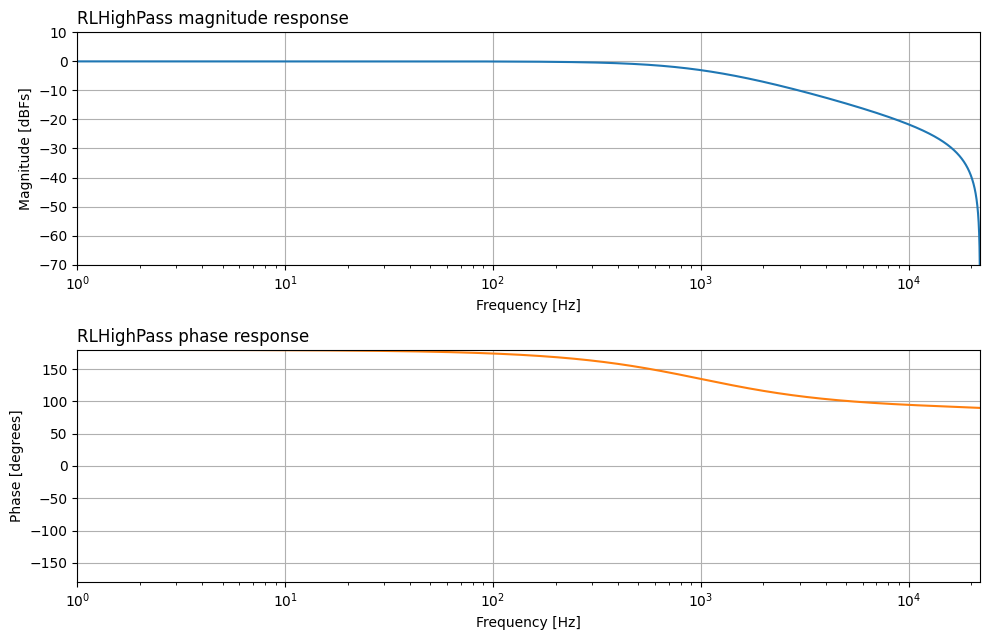

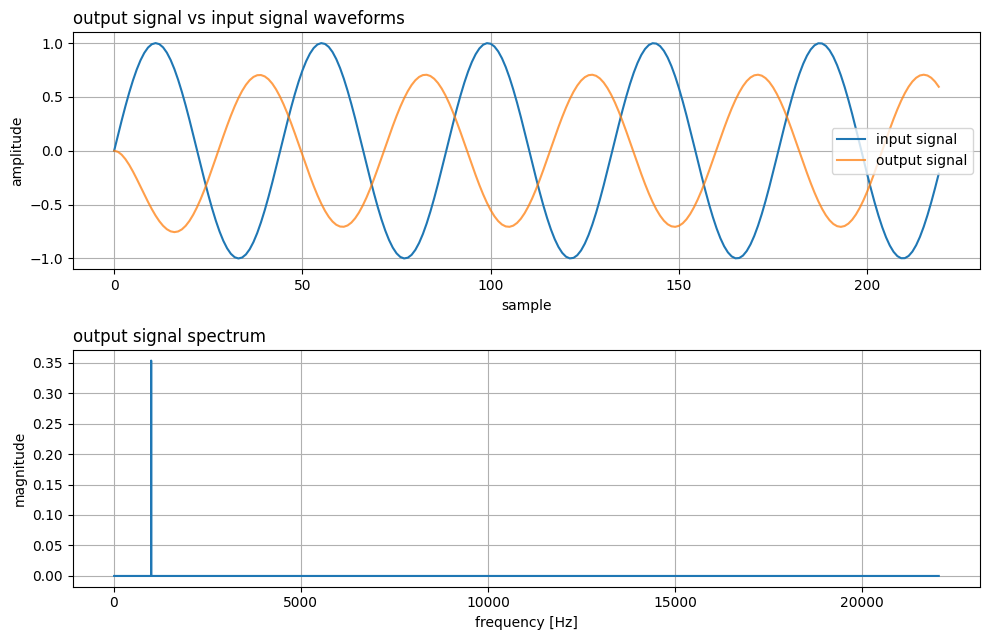

In [13]:
# 📊 Análisis del HighPass
hpf = RLHighPass(fs=44100, cutoff=1000)
hpf.plot_freqz()
hpf.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)

In [14]:
# 📘 3. Comparación analógica vs WDF
# Puedes comparar estas salidas con:
# - La función de transferencia analítica.
# - Resultados de JUCE (WDFRCLowPass) y LTSpice.
# - Exportando respuestas a .wav o .csv.
#
# Esto valida que el modelo WDF:
# ✅ Coincide en comportamiento espectral  
# ✅ Responde bien a señales transitorias  
# ✅ Está listo para ser embebido en un plugin VST

# 🧪 Exportar impulsos o salidas para comparación
impulse = lpf.get_impulse_response(delta_dur=1, amp=1)
write("rc_lowpass_impulse.wav", 44100, impulse.astype(np.float32))

impulse = hpf.get_impulse_response(delta_dur=1, amp=1)
write("rl_highpass_impulse.wav", 44100, impulse.astype(np.float32))

# ✅ Próximo notebook: 07_Comparaciones_JUCE_LTSpice.ipynb
# Ahí compararemos:
# - Salidas de pywdf
# - Resultados de LTSpice (por tus compañeros)
# - Plugin VST hecho en JUCE

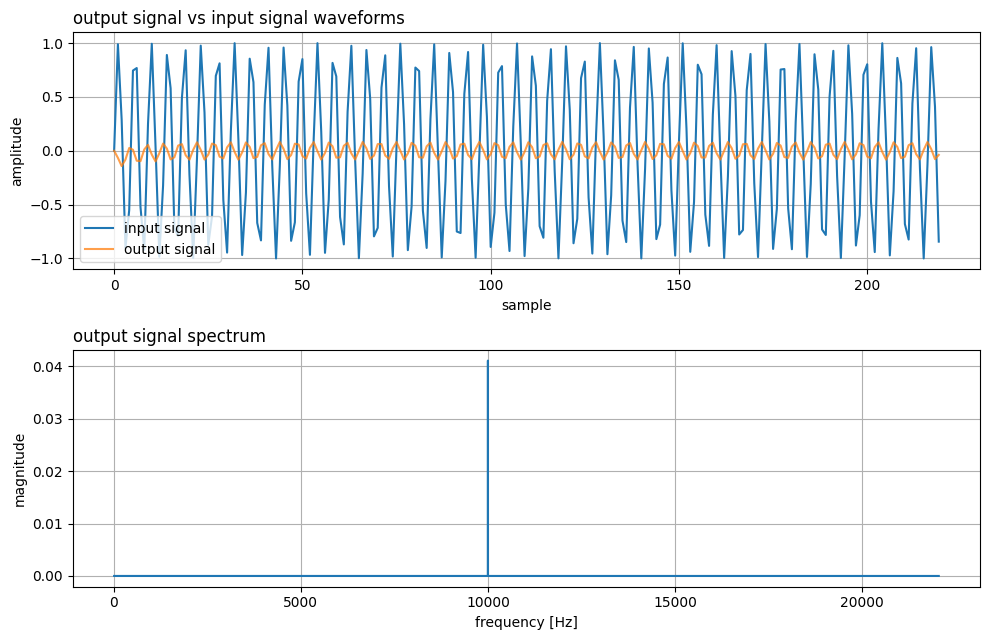

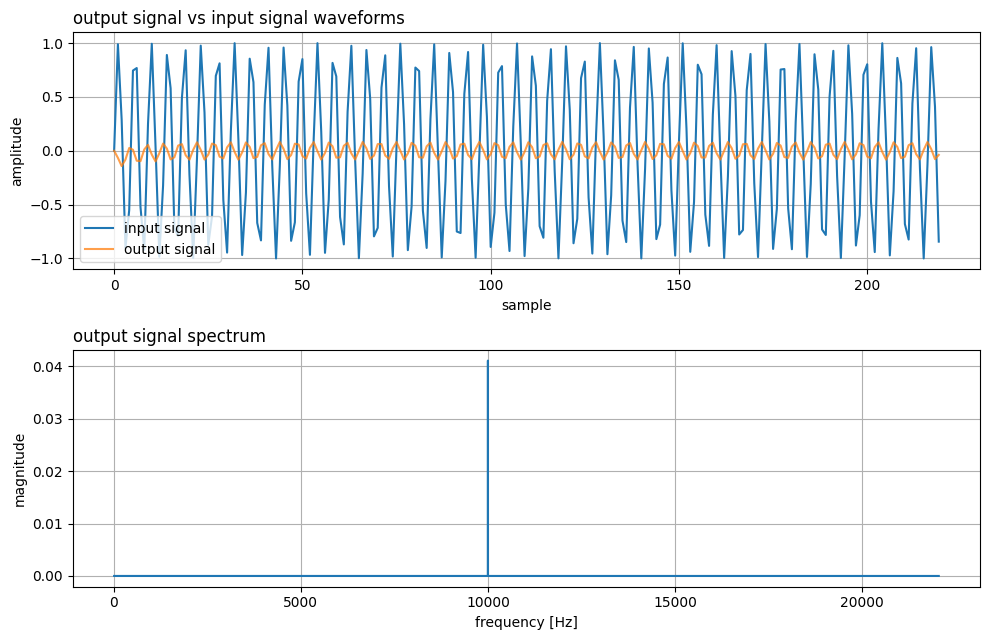

In [15]:
lpf.AC_transient_analysis(freq=10000, amplitude=1.0, t_ms=5)
hpf.AC_transient_analysis(freq=10000, amplitude=1.0, t_ms=5)



In [16]:
print("Resistor Rp:", hpf.R1.Rp)
print("Inductor Rp:", hpf.L1.Rp)
print("SeriesAdaptor Rp:", hpf.S1.Rp)
print("Output node:", type(hpf.output).__name__)


Resistor Rp: 6.283185307179586
Inductor Rp: 88.2
SeriesAdaptor Rp: 94.48318530717958
Output node: Resistor


In [17]:
print("Resistor Rp:", lpf.R1.Rp)
print("Capacitor Rp:", lpf.C1.Rp)
print("SeriesAdaptor Rp:", lpf.S1.Rp)
print("Output node:", type(lpf.output).__name__)


Resistor Rp: 159.15494309189535
Capacitor Rp: 11.337868480725623
SeriesAdaptor Rp: 170.49281157262098
Output node: Capacitor


In [18]:
print("LPF output voltage sample:", lpf.output.wave_to_voltage())
print("HPF output voltage sample:", hpf.output.wave_to_voltage())


LPF output voltage sample: 0.018607112971758766
HPF output voltage sample: 0.018607112971758894


## OJO!

### Ambos filtros están generando el mismo output a la hora de realizar el análisis y esto no debería suceder.